<a id="top"></a>

# Credit Card Fraud (Classification)

# Outline

- [Read Data](#read_data)
- [Create target and features](#create_y_and_X)
- [Split data into train and test](#train_test_split)
- [View descriptive statistics](#descriptive_statistics)
- [View target and feature distributions](#distributions)
- [View correlations](#correlations)
- [View relationships between target and features](#pair_plots)
- [Standardize predictors](#standardize_predictors)
- [Predictive models](#predictive_models)
- [Logistic regression](#logistic_regression)
- [K-nearest neighbors](#k_nearest_neighbors)
- [Linear discriminant analysis](#linear_discriminant_analysis)
- [Support vector machines](#support_vector_machines)
- [Random Forest](#random_forest)
- [Compare models](#compare_models)
- [Oversampling](#oversampling)
- [Statsmodels](#statsmodels)

# Import packages

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from time import time
from pprint import pprint

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, plot_roc_curve, plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, cohen_kappa_score, precision_recall_fscore_support

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

<a id="read_data"></a>

# [Read data](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)

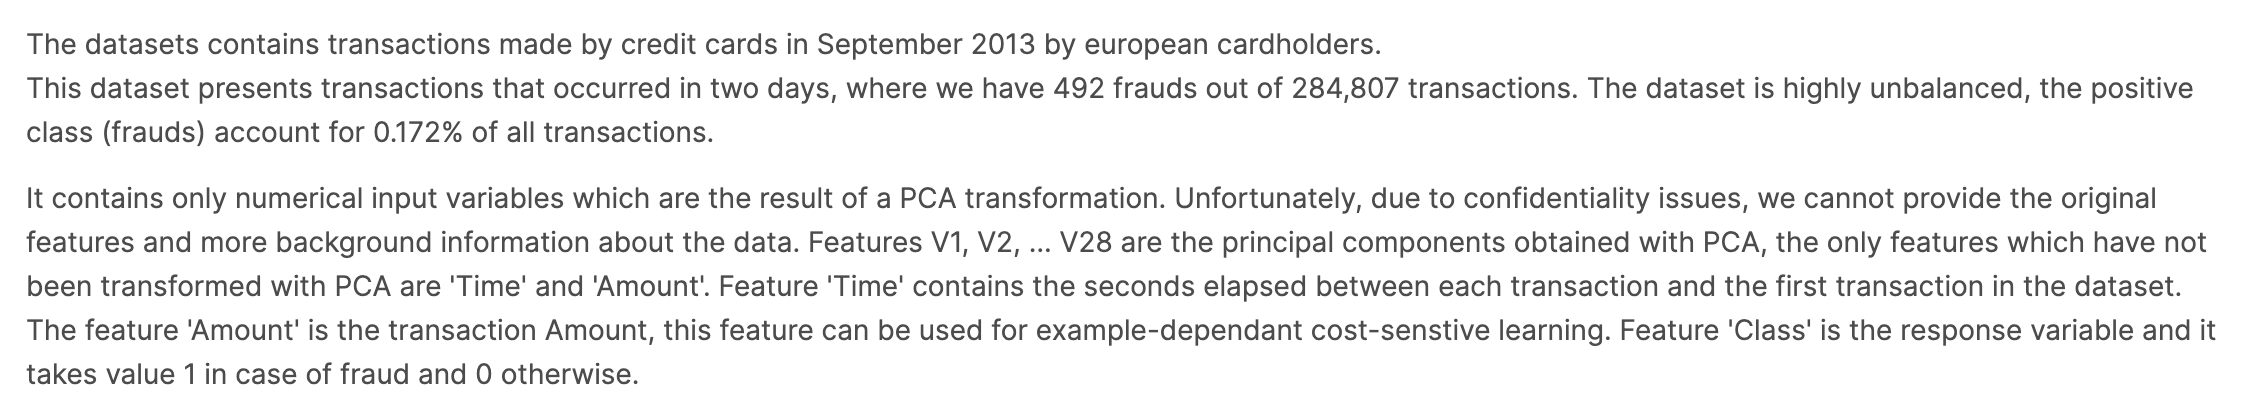

In [4]:
Image(filename='../images/credit_card_fraud_dataset_description.png', width=1000)

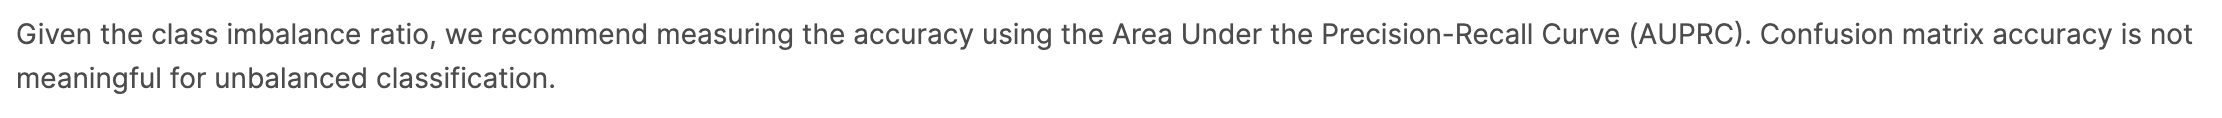

In [5]:
Image(filename='../images/credit_card_fraud_dataset_recommended_evaluation_metric.png', width=1000)

In [9]:
infile = 'https://github.com/cbrownley/2022MLWEEK_MLWITHPYTHON/blob/main/data/credit_card_fraud.csv.zip'

In [10]:
df = pd.read_csv(infile, compression='gzip')

['{}: {}'.format(i, name) for (i, name) in enumerate(list(df.columns))]

BadGzipFile: Not a gzipped file (b'\n\n')

In [ ]:
df.head(10)

In [ ]:
df.shape

In [ ]:
pd.concat([df['class'].value_counts(), 
           df['class'].value_counts(normalize=True).round(5)], axis=1)

# Downsample to reduce model fitting time

In [ ]:
y0_downsampled = df.loc[df['class'] == 0, :].sample(frac=0.05, replace=False, random_state=1)
y1_downsampled = df.loc[df['class'] == 1, :].sample(frac=0.05, replace=False, random_state=1)

In [ ]:
df_downsampled = pd.concat([y0_downsampled, y1_downsampled], axis=0)

In [ ]:
pd.concat([df_downsampled['class'].value_counts(), 
           df_downsampled['class'].value_counts(normalize=True).round(5)], axis=1)

<a id="create_y_and_X"></a>

# Create target, y, and predictor, X, variables

In [ ]:
neg, pos = np.bincount(df_downsampled['class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.3f}% of total)\n'.format(
    total, pos, 100 * pos / total))

In [ ]:
X = df_downsampled.iloc[:, 1:].values
y = df_downsampled['class'].values.astype(int)

y_labels = ['Not Fraud', 'Fraud']

print('Class labels:', np.unique(y), y_labels, [(i, val) for (i, val) in enumerate(np.bincount(y))])

<a id="train_test_split"></a>

# Split data into train and test sets

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
X_train

In [ ]:
print('Labels counts in y:',       np.bincount(y),       
      [round(cnt / np.sum(np.bincount(y)) * 100, 1) for cnt in np.bincount(y)])

print('Labels counts in y_train:', np.bincount(y_train), 
      [round(cnt / np.sum(np.bincount(y_train)) * 100, 1) for cnt in np.bincount(y_train)])

print('Labels counts in y_test:',  np.bincount(y_test),  
      [round(cnt / np.sum(np.bincount(y_test)) * 100, 1) for cnt in np.bincount(y_test)])

<a id="descriptive_statistics"></a>

# View descriptive statistics

In [ ]:
data = pd.DataFrame(np.hstack((y_train.reshape(-1,1), X_train)), 
                    columns=list(df.columns))

data.describe().T.round(2)

<a id="distributions"></a>

# View target distribution

In [ ]:
plt.subplots(figsize=(8,6))
sns.distplot(data['class'], kde=False);

# View predictor distributions by target category

In [ ]:
f, axs = plt.subplots(15, 2, figsize=(20,70))

for i, feat in enumerate(X_train.T):
    sns.distplot(feat[y_train==0], ax=axs.flat[i], label='{}: {}'.format('Not Fraud', len(y_train[y_train==0])))
    sns.distplot(feat[y_train==1], ax=axs.flat[i], label='{}: {}'.format('Fraud',     len(y_train[y_train==1])))
    axs.flat[i].set_title('{}:  mean: {}  std: {}'.format(list(data.columns)[i+1], abs(feat.mean().round(2)), feat.std().round(2)))
    axs.flat[i].legend()
plt.tight_layout();

<a id="correlations"></a>

# View predictor correlations

In [ ]:
plt.figure(figsize=(30, 30))

matrix = np.triu(data.corr())
sns.heatmap(data.corr(), 
            annot=True, fmt='.2g', 
            mask=matrix, 
            vmin=-1, vmax=1, center=0, 
            cmap=sns.diverging_palette(20, 220, n=100));

<a id="pair_plots"></a>

# Visualize distributions of, and relationships between, target and predictors

In [ ]:
sns.pairplot(data.iloc[:, :7], 
             vars=list(data.columns)[:7], 
             kind='reg',
             diag_kind='hist',
             hue='class', 
             # markers=['o', 's'], 
             corner=True,  
             plot_kws={'scatter_kws': {'alpha': 0.05}, 
                       'x_jitter': 0.1, 'y_jitter': 0.1});

In [ ]:
sns.pairplot(pd.concat([data.iloc[:, 0], data.iloc[:, 8:15]], axis=1), 
             vars=[list(data.columns)[0]]+list(data.columns)[8:15], 
             kind='reg',
             diag_kind='hist',
             hue='class', 
             corner=True,  
             plot_kws={'scatter_kws': {'alpha': 0.05}, 
                       'x_jitter': 0.1, 'y_jitter': 0.1});

In [ ]:
sns.pairplot(pd.concat([data.iloc[:, 0], data.iloc[:, 15:23]], axis=1), 
             vars=[list(data.columns)[0]]+list(data.columns)[15:23], 
             kind='reg',
             diag_kind='hist',
             hue='class', 
             corner=True,  
             plot_kws={'scatter_kws': {'alpha': 0.05}, 
                       'x_jitter': 0.1, 'y_jitter': 0.1});

In [ ]:
sns.pairplot(pd.concat([data.iloc[:, 0], data.iloc[:, 23:]], axis=1), 
             vars=[list(data.columns)[0]]+list(data.columns)[23:], 
             kind='reg',
             diag_kind='hist',
             hue='class', 
             corner=True,  
             plot_kws={'scatter_kws': {'alpha': 0.05}, 
                       'x_jitter': 0.1, 'y_jitter': 0.1});

<a id="standardize_predictors"></a>

# [Standardize](https://scikit-learn.org/stable/modules/preprocessing.html) the Predictors

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std  = sc.transform(X_test)

# View standardized predictor distributions by target category

In [ ]:
f, axs = plt.subplots(15, 2, figsize=(20,70))

for i, feat in enumerate(X_train_std.T):
    sns.distplot(feat[y_train==0], ax=axs.flat[i], label='{}: {}'.format('Not Fraud', len(y_train[y_train==0])))
    sns.distplot(feat[y_train==1], ax=axs.flat[i], label='{}: {}'.format('Fraud',     len(y_train[y_train==1])))
    axs.flat[i].set_title('{}:  mean: {}  std: {}'.format(list(data.columns)[i+1], abs(feat.mean().round(2)), feat.std().round(2)))
    axs.flat[i].legend()
plt.tight_layout();

<a id="predictive_models"></a>

# Predictive Models

# [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) estimator

In [ ]:
from sklearn.dummy import DummyClassifier

d_clf = DummyClassifier(strategy='constant', constant=0)
d_clf.fit(X_train_std, y_train)

print('Accuracy (train): {:.3f}'.format(d_clf.score(X_train_std, y_train)))
print('Accuracy  (test): {:.3f}'.format(d_clf.score(X_test_std,  y_test)))

# [Confusion matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)

In [ ]:
from sklearn.metrics import plot_confusion_matrix

f, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(d_clf, X_test_std, y_test, 
                      ax=ax,
                      display_labels=y_labels, 
                      cmap=plt.cm.Blues, 
                      values_format='d', # for float: '.2g'
                      normalize=None);

# [Classification report](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report)

In [ ]:
from sklearn.metrics import classification_report

y_pred = d_clf.predict(X_test_std)

print(classification_report(y_test, y_pred, 
                            target_names=y_labels))

# [ROC curve](https://scikit-learn.org/stable/auto_examples/plot_roc_curve_visualization_api.html)

In [ ]:
from sklearn.metrics import plot_roc_curve

f, ax = plt.subplots(figsize=(8,6))
plot_roc_curve(d_clf, X_test_std, y_test, ax=ax, color='orange');

<a id="logistic_regression"></a>

# [Logistic Regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

# Cs: Each of the values in Cs describes the inverse of regularization strength

# L1 Ratio: A value of 0 is equivalent to using penalty='l2'
#           A value of 1 is equivalent to using penalty='l1'
#           For 0 < l1_ratio <1, the penalty is a combination of L1 and L2
lr_clf = LogisticRegressionCV(cv=3, 
                              penalty='elasticnet', solver='saga', 
                              Cs=np.power(10, np.arange(-3, 1, dtype=float)), 
                              l1_ratios=np.linspace(0, 1, num=6, dtype=float), 
                              max_iter=1000, 
                              random_state=0, 
                              n_jobs=3)

start = time()
lr_clf.fit(X_train_std, y_train)
lr_duration = time() - start

print("LogisticRegressionCV took {:.2f} seconds for {} cv iterations with {} parameter settings.".format(lr_duration, 
                                                                                                         lr_clf.n_iter_.shape[1], 
                                                                                                         lr_clf.n_iter_.shape[2] * lr_clf.n_iter_.shape[3]))

print('Optimal regularization strength: {}  Optimal L1 Ratio: {}'.format(lr_clf.C_[0], lr_clf.l1_ratio_[0]))
print('Accuracy (train): {:.2f}'.format(lr_clf.score(X_train_std, y_train)))
print('Accuracy  (test): {:.2f}'.format(lr_clf.score(X_test_std,  y_test)))

## Model parameters

In [ ]:
lr_params = dict(zip(list(data.columns)[1:], list(lr_clf.coef_[0])), 
                 intercept=lr_clf.intercept_[0])
{param: value.round(2) for (param, value) in sorted(lr_params.items(), key=lambda item: item[1], reverse=True)}

## Predicted class labels

In [ ]:
predicted_class_labels = lr_clf.predict(X_test_std)
predicted_class_labels

## Predicted probabilities of class labels

In [ ]:
predicted_class_probabilities = lr_clf.predict_proba(X_test_std)
[dict(zip(['Not Fraud(0)', 'Fraud(1)'], map(lambda val: val.round(3), list(arr))), obs_id=i) 
 for (i, arr) in enumerate(list(predicted_class_probabilities))]

## Cross-validation score on test set

In [ ]:
from sklearn.model_selection import cross_val_score

def get_cross_val(clf, X, y, model_name, cv_num=5, metric='f1'):
    scores = cross_val_score(clf, X, y, cv=cv_num, scoring=metric)
    mean = scores.mean()
    std  = scores.std()
    p025 = np.quantile(scores, 0.025)
    p975 = np.quantile(scores, 0.975)
    metrics = ['mean', 'standard deviation', 'p025', 'p975']
    s = pd.Series([mean, std, p025, p975], index=metrics)  # np.where(lb < 0, 0, lb), np.where(ub > 1, 1, ub)
    s.name = model_name
    return s

In [ ]:
lr_cv = get_cross_val(lr_clf, X_test_std, y_test, 'logistic regression')
lr_cv.round(2)

## Confusion matrix

In [ ]:
f, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(lr_clf, X_test_std, y_test, 
                      ax=ax,
                      display_labels=y_labels, 
                      cmap=plt.cm.Blues, 
                      values_format='d', # '.2g'
                      normalize=None);

## Classification report

In [ ]:
y_pred = lr_clf.predict(X_test_std)

print(classification_report(y_test, y_pred, 
                            target_names=y_labels))

## A collection of metrics for comparing models

In [ ]:
def calculate_metrics(y_true, y_pred, duration, model_name, *args):
    acc     = accuracy_score(y_true, y_pred)
    pre     = precision_score(y_true, y_pred)
    rec     = recall_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    f1      = f1_score(y_true, y_pred)
    ck      = cohen_kappa_score(y_true, y_pred)
    p, r, fbeta, support = precision_recall_fscore_support(y_true, y_pred)
    metrics = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1_score', 'cohen_kappa',  
               'precision_both', 'recall_both', 'fbeta_both', 'support_both', 'time_to_fit (seconds)']
    s = pd.Series([acc, pre, rec, roc_auc, f1, ck, p, r, fbeta, support, duration], index=metrics)
    s.name = model_name
    return s

In [ ]:
lr_metrics = calculate_metrics(y_test, y_pred, lr_duration, 'logistic_regression')
lr_metrics

## ROC curve

In [ ]:
f, ax = plt.subplots(figsize=(8,6))
plot_roc_curve(lr_clf, X_test_std, y_test, ax=ax, color='blue');

<a id="k_nearest_neighbors"></a>

# K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'weights': ['uniform', 'distance'],
              'n_neighbors': np.arange(1,16)}

knn_clf = KNeighborsClassifier()

gs_knn = GridSearchCV(knn_clf, param_grid=param_grid)

start = time()
gs_knn.fit(X_train_std, y_train)
knn_duration = time() - start

print("GridSearchCV of KNN took {:.2f} seconds for {} candidate parameter settings.".format(knn_duration, 
                                                                                            len(gs_knn.cv_results_['params'])))
# report(gs_knn.cv_results_)
print('Optimal weights: {}  Optimal n_neighbors: {}'.format(gs_knn.best_params_['weights'], gs_knn.best_params_['n_neighbors']))
print('Accuracy (train): {:.2f}'.format(gs_knn.score(X_train_std, y_train)))
print('Accuracy  (test): {:.2f}'.format(gs_knn.score(X_test_std,  y_test)))

## Best parameters

In [ ]:
pprint(gs_knn.best_estimator_.get_params())

## Cross-validation score on test set

In [ ]:
knn_cv = get_cross_val(gs_knn, X_test_std, y_test, 'k-nearest neighbors')
knn_cv.round(2)

## Confusion matrix

In [ ]:
f, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(gs_knn, X_test_std, y_test, 
                      ax=ax,
                      display_labels=y_labels, 
                      cmap=plt.cm.Blues, 
                      values_format='d', # '.2g'
                      normalize=None);

## Classification report

In [ ]:
y_pred = gs_knn.predict(X_test_std)

print(classification_report(y_test, y_pred, 
                            target_names=y_labels))

## A collection of metrics for comparing models

In [ ]:
knn_metrics = calculate_metrics(y_test, y_pred, knn_duration, 'k-nearest neighbors')
knn_metrics

## ROC curve

In [ ]:
f, ax = plt.subplots(figsize=(8,6))
plot_roc_curve(gs_knn, X_test_std, y_test, ax=ax, color='blue');

<a id="linear_discriminant_analysis"></a>

# Linear Discriminant Analysis

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

param_grid = {'solver': ['lsqr', 'eigen'],
              'shrinkage': [None, 'auto'], 
              'n_components': np.arange(1,5)}

lda_clf = LinearDiscriminantAnalysis()

gs_lda = GridSearchCV(lda_clf, param_grid=param_grid)

start = time()
gs_lda.fit(X_train_std, y_train)
lda_duration = time() - start

print("GridSearchCV of LDA took {:.2f} seconds for {} candidate parameter settings.".format(lda_duration, 
                                                                                            len(gs_lda.cv_results_['params'])))
# report(gs_lda.cv_results_)
print('Optimal solver: {}  Optimal shrinkage: {}  Optimal n_components: {}'.format(gs_lda.best_params_['solver'], gs_lda.best_params_['shrinkage'], gs_lda.best_params_['n_components']))
print('Accuracy (train): {:.2f}'.format(gs_lda.score(X_train_std, y_train)))
print('Accuracy  (test): {:.2f}'.format(gs_lda.score(X_test_std,  y_test)))

## Cross-validation score on test set

In [ ]:
lda_cv = get_cross_val(lda_clf, X_test_std, y_test, 'linear discriminanat analysis')
lda_cv.round(2)

## Confusion matrix

In [ ]:
f, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(gs_lda, X_test_std, y_test, 
                      ax=ax,
                      display_labels=y_labels, 
                      cmap=plt.cm.Blues, 
                      values_format='d', # '.2g'
                      normalize=None);

## Classification report

In [ ]:
y_pred = gs_lda.predict(X_test_std)

print(classification_report(y_test, y_pred, 
                            target_names=y_labels))

## A collection of metrics for comparing models

In [ ]:
lda_metrics = calculate_metrics(y_test, y_pred, lda_duration, 'linear discriminant analysis')
lda_metrics

## ROC curve

In [ ]:
f, ax = plt.subplots(figsize=(8,6))
plot_roc_curve(gs_lda, X_test_std, y_test, ax=ax, color='blue');

<a id="support_vector_machines"></a>

# Support Vector Machines

In [ ]:
from sklearn.svm import SVC

param_grid = {'C': np.power(10, np.arange(0, 3, dtype=float)),
              'kernel': ['linear', 'sigmoid', 'rbf'], 
              'gamma': ['auto', 'scale']}

svc_clf = SVC(random_state=0)

gs_svc = GridSearchCV(svc_clf, param_grid=param_grid)

start = time()
gs_svc.fit(X_train_std, y_train)
svc_duration = time() - start

print("GridSearchCV of SVC took {:.2f} seconds for {} candidate parameter settings.".format(svc_duration, 
                                                                                            len(gs_svc.cv_results_['params'])))
# report(gs_svc.cv_results_)
print('Optimal C: {}  Optimal kernel: {}  Optimal gamma: {}'.format(gs_svc.best_params_['C'], gs_svc.best_params_['kernel'], gs_svc.best_params_['gamma']))
print('Accuracy (train): {:.2f}'.format(gs_svc.score(X_train_std, y_train)))
print('Accuracy  (test): {:.2f}'.format(gs_svc.score(X_test_std,  y_test)))

## Cross-validation score on test set

In [ ]:
svc_cv = get_cross_val(gs_svc, X_test_std, y_test, 'support vector machines')
svc_cv.round(2)

## Confusion matrix

In [ ]:
f, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(gs_svc, X_test_std, y_test, 
                      ax=ax,
                      display_labels=y_labels, 
                      cmap=plt.cm.Blues, 
                      values_format='d', # '.2g'
                      normalize=None);

## Classification report

In [ ]:
y_pred = gs_svc.predict(X_test_std)

print(classification_report(y_test, y_pred, 
                            target_names=y_labels))

## A collection of metrics for comparing models

In [ ]:
svc_metrics = calculate_metrics(y_test, y_pred, svc_duration, 'support vector machines')
svc_metrics

## ROC curve

In [ ]:
f, ax = plt.subplots(figsize=(8,6))
plot_roc_curve(gs_svc, X_test_std, y_test, ax=ax, color='blue');

<a id="random_forest"></a>

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': np.arange(100, 1000, 200, dtype=int),
              'max_features': [None, 'sqrt', 'log2'],
              'max_depth': [None, 3, 5]}

rf_clf = RandomForestClassifier(oob_score=True, random_state=0)

gs_rf = GridSearchCV(rf_clf, param_grid=param_grid)

start = time()
gs_rf.fit(X_train_std, y_train)
rf_duration = time() - start

print("GridSearchCV of RF took {:.2f} seconds for {} candidate parameter settings.".format(rf_duration, 
                                                                                           len(gs_rf.cv_results_['params'])))
# report(gs_rf.cv_results_)
print('Optimal n_estimators: {}  Optimal max_features: {}  Optimal max_depth: {}'.format(gs_rf.best_params_['n_estimators'], 
                                                                                         gs_rf.best_params_['max_features'], 
                                                                                         gs_rf.best_params_['max_depth']))
print('Accuracy (train): {:.2f}'.format(gs_rf.score(X_train_std, y_train)))
print('Accuracy  (test): {:.2f}'.format(gs_rf.score(X_test_std,  y_test)))

## Cross-validation score on test set

In [ ]:
clf_rf = RandomForestClassifier(n_estimators=gs_rf.best_params_['n_estimators'], 
                                max_features=gs_rf.best_params_['max_features'], 
                                max_depth=gs_rf.best_params_['max_depth'], 
                                oob_score=True, 
                                random_state=0)

rf_cv = get_cross_val(clf_rf, X_test_std, y_test, 'random forest')
rf_cv.round(2)

## Confusion matrix

In [ ]:
f, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(gs_rf, X_test_std, y_test, 
                      ax=ax,
                      display_labels=y_labels, 
                      cmap=plt.cm.Blues, 
                      values_format='d', # '.2g'
                      normalize=None);

## Classification report

In [ ]:
y_pred = gs_rf.predict(X_test_std)

print(classification_report(y_test, y_pred, 
                            target_names=y_labels))

## A collection of metrics for comparing models

In [ ]:
rf_metrics = calculate_metrics(y_test, y_pred, rf_duration, 'random forest')
rf_metrics

## ROC curve

In [ ]:
f, ax = plt.subplots(figsize=(8,6))
plot_roc_curve(gs_rf, X_test_std, y_test, ax=ax, color='blue');

## Variable importances in the random forest model

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(gs_rf, X_test_std, y_test, n_repeats=10,
                                random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

X_test_df = pd.DataFrame(X_test_std, columns=list(data.columns)[1:])

f, ax = plt.subplots(figsize=(8,16))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test_df.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
plt.tight_layout();

<a id="compare_models"></a>

# Compare Models

## Classification metrics scores and time-to-fit models (in seconds)

In [ ]:
model_metrics = pd.concat([lr_metrics, knn_metrics, lda_metrics, svc_metrics, rf_metrics], axis=1).T

model_metrics.apply(lambda elem: [np.round(val, 2) for val in elem]).sort_values(by='f1_score', ascending=False)

## Cross-validation scores on test set

In [ ]:
cross_vals = pd.concat([lr_cv, knn_cv, lda_cv, svc_cv, rf_cv], axis=1).T

cross_vals = cross_vals.round(2).sort_values(by='mean', ascending=False)
cross_vals

## Plot of mean (+/- std) cross-validation scores

In [ ]:
fig = plt.figure(figsize=(8,6))

for i in range(len(cross_vals.index)):
    plt.errorbar(x=i, y=cross_vals.iloc[i, 0], # mean column
                 xerr=0.25,
                 yerr=cross_vals.iloc[i, 1], # standard deviation column   alternatively: [mean - p025, p975 - mean],
                 linestyle='',
                 label=list(cross_vals.index)[i])

#plt.ylim(0.7,1)
plt.title('Mean F1 Score (+/- 1 std) by Model,\nbased on 5-fold cross-validation on the test set')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.legend(loc='lower left');

<a id="oversampling"></a>

# [Oversampling](https://github.com/scikit-learn-contrib/imbalanced-learn/wiki)

## Using [NumPy](https://numpy.org/devdocs/)

In [ ]:
bool_y_train = y_train != 0

pos_features = X_train_std[bool_y_train]
neg_features = X_train_std[~bool_y_train]

pos_labels = y_train[bool_y_train]
neg_labels = y_train[~bool_y_train]

pos_features.shape, neg_features.shape

## Oversample the minority class

In [ ]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels   = pos_labels[choices]

res_pos_features.shape, res_pos_labels.shape

# Recombine oversampled minority class and majority class

In [ ]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels   = np.concatenate([res_pos_labels,   neg_labels],   axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)

resampled_features = resampled_features[order]
resampled_labels   = resampled_labels[order]

resampled_features.shape, resampled_labels.shape

# Linear Discriminant Analysis

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

param_grid = {'solver': ['lsqr', 'eigen'],
              'shrinkage': [None, 'auto'], 
              'n_components': np.arange(1,5)}

lda_clf = LinearDiscriminantAnalysis()

gs_lda_resamp = GridSearchCV(lda_clf, param_grid=param_grid)

start = time()
gs_lda_resamp.fit(resampled_features, resampled_labels)
lda_duration = time() - start

print("GridSearchCV of LDA took {:.2f} seconds for {} candidate parameter settings.".format(lda_duration, 
                                                                                            len(gs_lda_resamp.cv_results_['params'])))
# report(gs_lda.cv_results_)
print('Optimal solver: {}  Optimal shrinkage: {}  Optimal n_components: {}'.format(gs_lda_resamp.best_params_['solver'], 
                                                                                   gs_lda_resamp.best_params_['shrinkage'], 
                                                                                   gs_lda_resamp.best_params_['n_components']))
print('Accuracy (train): {:.2f}'.format(gs_lda_resamp.score(resampled_features, resampled_labels)))
print('Accuracy  (test): {:.2f}'.format(gs_lda_resamp.score(X_test_std,  y_test)))

# Using [imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html)

# Oversample the minority class

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)

X_resampled, y_resampled = ros.fit_resample(X_train_std, y_train)

from collections import Counter
print(sorted(Counter(y_resampled).items()))

# Linear Discriminant Analysis

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

param_grid = {'solver': ['lsqr', 'eigen'],
              'shrinkage': [None, 'auto'], 
              'n_components': np.arange(1,5)}

lda_clf = LinearDiscriminantAnalysis()

gs_lda_resamp = GridSearchCV(lda_clf, param_grid=param_grid)

start = time()
gs_lda_resamp.fit(resampled_features, resampled_labels)
lda_duration = time() - start

print("GridSearchCV of LDA took {:.2f} seconds for {} candidate parameter settings.".format(lda_duration, 
                                                                                            len(gs_lda_resamp.cv_results_['params'])))
# report(gs_lda.cv_results_)
print('Optimal solver: {}  Optimal shrinkage: {}  Optimal n_components: {}'.format(gs_lda_resamp.best_params_['solver'], 
                                                                                   gs_lda_resamp.best_params_['shrinkage'], 
                                                                                   gs_lda_resamp.best_params_['n_components']))
print('Accuracy (train): {:.2f}'.format(gs_lda_resamp.score(resampled_features, resampled_labels)))
print('Accuracy  (test): {:.2f}'.format(gs_lda_resamp.score(X_test_std,  y_test)))

<a id="statsmodels"></a>

# [Statsmodels](https://www.statsmodels.org/stable/index.html)

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Instantiate the model
logit = sm.Logit(y_train, X_train_std)

# Fit the model
result = logit.fit()

# View the model summary
result.summary()

In [ ]:
# View odds ratios and 95% CIs
# Source: https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.LogitResults.html
params = result.params

conf = result.conf_int()

conf = pd.DataFrame(conf, columns=['2.5%', '97.5%'])
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']

np.exp(conf).round(3)

In [ ]:
# View marginal effects of the fitted model
# Source: https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.LogitResults.html
marginal_effects = result.get_margeff()
marginal_effects.summary()

# [Predict](https://www.statsmodels.org/stable/examples/notebooks/generated/predict.html)

In [ ]:
# Make predictions
y_pred = result.predict(X_test_std)
y_pred

In [ ]:
# Convert predicted probabilities to predicted classes
y_pred_class = np.where(y_pred > 0.50, 1, 0)
y_pred_class

In [ ]:
print(classification_report(y_test, y_pred_class, 
                            target_names=y_labels))

[Back to top](#top)